<h2>Abstract</h2>
<p>
This notebook is an experiment of SCDV.<br>
It will calculate document vectors using SCDV and some methods e.g. BoW, TF-IDF, averaged Word2Vec and Doc2Vec.<br>
Then, compare with distributeions of each document vectors using t-SNE plots.<br>
Then, train models using each document vectors, and compare accuracies.
</p>

<h2>(1) Library</h2>

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import sklearn
from sklearn import datasets
import gensim
import xgboost

from src.constants import SEED
from src.utils import logger, fix_seed
from src.document_vectors import (
    calc_bow,
    calc_tfidf,
    calc_avg_word2vec,
    calc_doc2vec,
    calc_scdv,
)
from src.functions import (
    to_tsne_df,
    compare_xgboost_accuracy,
)

fix_seed(SEED)

In [2]:
print("numpy version: {}".format(np.__version__))
print("pandas version: {}".format(pd.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("seaborn version: {}".format(sns.__version__))
print("scikit-learn version: {}".format(sklearn.__version__))
print("gensim version: {}".format(gensim.__version__))
print("xgboost version: {}".format(xgboost.__version__))

numpy version: 1.23.5
pandas version: 1.5.2
matplotlib version: 3.6.2
seaborn version: 0.12.1
scikit-learn version: 1.2.0
gensim version: 4.2.0
xgboost version: 1.7.2


<h2>(2) Load data</h2>

In [3]:
categories = [
    "alt.atheism",
    "comp.graphics",
    "rec.sport.baseball",
    "sci.space",
    "talk.politics.guns",
]
train = datasets.fetch_20newsgroups(subset="train", categories=categories)
train.data = np.array(train.data, dtype=np.object)

for i, c in enumerate(categories):
    indices = np.where(train.target == i)
    print(c + ": {}".format(len(train.data[indices])))
print("-" * 20)
print("total: {}".format(len(train.data)))

alt.atheism: 480
comp.graphics: 584
rec.sport.baseball: 597
sci.space: 593
talk.politics.guns: 546
--------------------
total: 2800


<h2>(3) Calculate document vectors and Compare</h2>
<p>
Calculate document vectors and compare with each distributed vectors using t-SNE.<br>
If a document vector of SCDV capture document features well, will not t-SNE plots also be clearly distributed?
</p>

In [4]:
# BoW
logger.info("Calculate BoW")
bows = calc_bow(corpus=train.data)
df_tsne_bow = to_tsne_df(in_vec=bows, targets=train.target)

# Tf-idf
logger.info("Calculate TF-IDF")
tfidfs, tfidf_vectorizer = calc_tfidf(corpus=train.data)
df_tsne_tfidf = to_tsne_df(in_vec=tfidfs, targets=train.target)

# averaged Word2Vec
logger.info("Calculate averaged Word2Vec")
avg_word2vecs, word2vecs = calc_avg_word2vec(corpus=train.data)
df_tsne_avg_word2vec = to_tsne_df(in_vec=avg_word2vecs, targets=train.target)

# Doc2Vec
logger.info("Calculate Doc2Vec")
doc2vecs = calc_doc2vec(corpus=train.data)
df_tsne_doc2vec = to_tsne_df(in_vec=doc2vecs, targets=train.target)

# SCDV
logger.info("Calculate SCDV")
scdvs = calc_scdv(
    corpus=train.data, word2vecs=word2vecs, tfidf_vectorizer=tfidf_vectorizer
)
df_tsne_scdv = to_tsne_df(in_vec=scdvs, targets=train.target)


dic_vecs = {
    "BoW": bows,
    "TF-IDF": tfidfs,
    "averaged Word2Vec": avg_word2vecs,
    "Doc2Vec": doc2vecs,
    "SCDV": scdvs,
}
dic_df_tsne = {
    "BoW": df_tsne_bow,
    "TF-IDF": df_tsne_tfidf,
    "averaged Word2Vec": df_tsne_avg_word2vec,
    "Doc2Vec": df_tsne_doc2vec,
    "SCDV": df_tsne_scdv,
}

[INFO] 2022/12/15 11:36:04 2 Calculate BoW
[INFO] 2022/12/15 11:36:04 55 Measuring time for <function calc_bow at 0x7f83d251ddc0>
[INFO] 2022/12/15 11:36:07 58 <function calc_bow at 0x7f83d251ddc0> took 2.57939 seconds
[INFO] 2022/12/15 11:36:07 55 Measuring time for <function to_tsne_df at 0x7f83d199cf70>
[INFO] 2022/12/15 11:36:27 58 <function to_tsne_df at 0x7f83d199cf70> took 19.81770 seconds
[INFO] 2022/12/15 11:36:27 7 Calculate TF-IDF
[INFO] 2022/12/15 11:36:27 55 Measuring time for <function calc_tfidf at 0x7f83d1995e50>
[INFO] 2022/12/15 11:36:30 58 <function calc_tfidf at 0x7f83d1995e50> took 3.75759 seconds
[INFO] 2022/12/15 11:36:30 55 Measuring time for <function to_tsne_df at 0x7f83d199cf70>
[INFO] 2022/12/15 11:36:56 58 <function to_tsne_df at 0x7f83d199cf70> took 25.96865 seconds
[INFO] 2022/12/15 11:36:56 12 Calculate averaged Word2Vec
[INFO] 2022/12/15 11:36:56 55 Measuring time for <function calc_avg_word2vec at 0x7f83d199caf0>
[INFO] 2022/12/15 11:37:07 58 <function

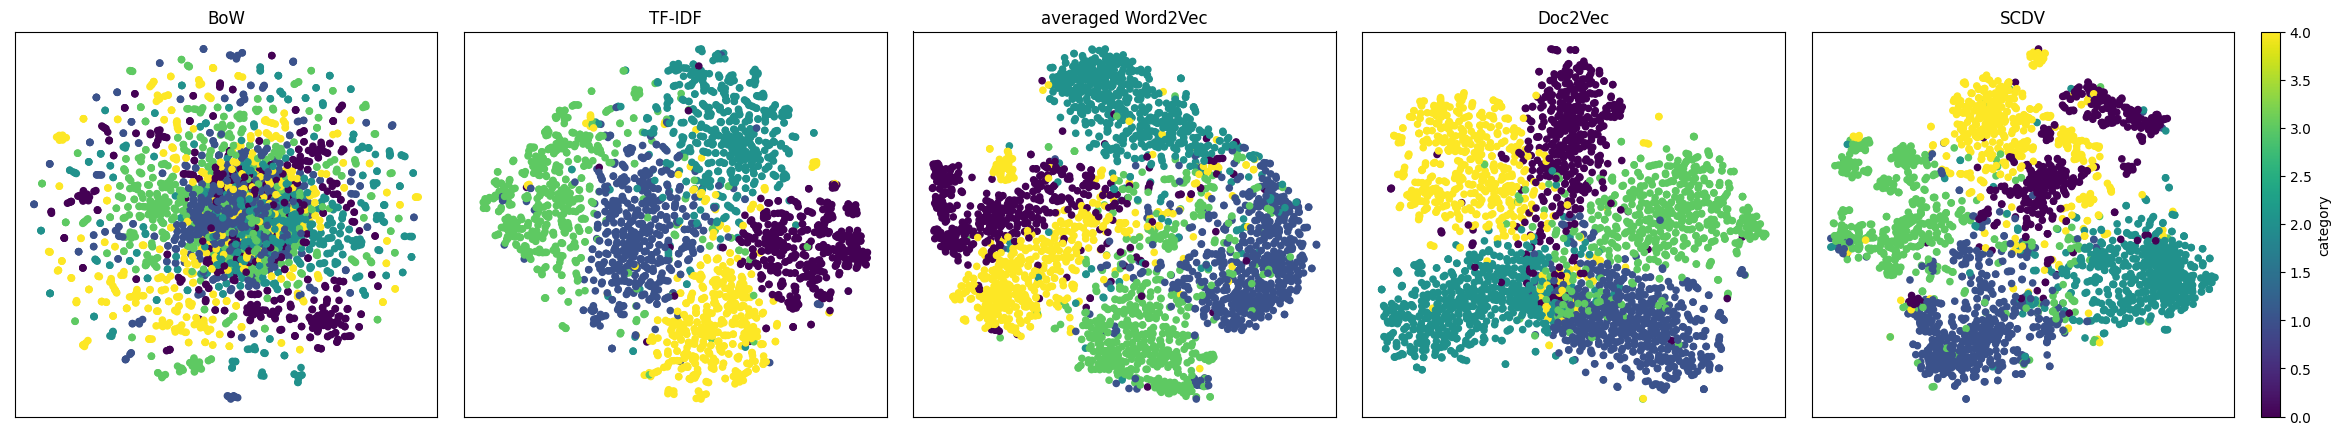

In [5]:
# Plot

fig, axs = plt.subplots(
    ncols=5, figsize=(30, 5), gridspec_kw={"width_ratios": [1, 1, 1, 1, 1.25]}
)

for i, (method, df_tsne) in enumerate(dic_df_tsne.items()):
    colorbar = True if i == (5 - 1) else False
    df_tsne.plot.scatter(
        x="x",
        y="y",
        c="category",
        colormap="viridis",
        s=20,
        ax=axs[i],
        title=method,
        colorbar=colorbar,
    )
    axs[i].axes.xaxis.set_visible(False)
    axs[i].axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.06)
plt.show()

<h2>(4) Compare model accuracy using each docment vectors</h2>
<p>
Next, train models using each document vectors, and compare accuracies.<br>
Will the model accuracy be more better using SCDV?
</p>

In [6]:
df_compare = compare_xgboost_accuracy(targets=train.target, dic_vecs=dic_vecs)

[INFO] 2022/12/15 11:40:44 55 Measuring time for <function compare_xgboost_accuracy at 0x7f83d19990d0>
[INFO] 2022/12/15 11:40:44 56 Train model using BoW
[INFO] 2022/12/15 11:56:35 56 Train model using TF-IDF
[INFO] 2022/12/16 12:12:48 56 Train model using averaged Word2Vec
[INFO] 2022/12/16 12:14:33 56 Train model using Doc2Vec
[INFO] 2022/12/16 12:16:44 56 Train model using SCDV
[INFO] 2022/12/16 01:17:28 58 <function compare_xgboost_accuracy at 0x7f83d19990d0> took 5803.84823 seconds


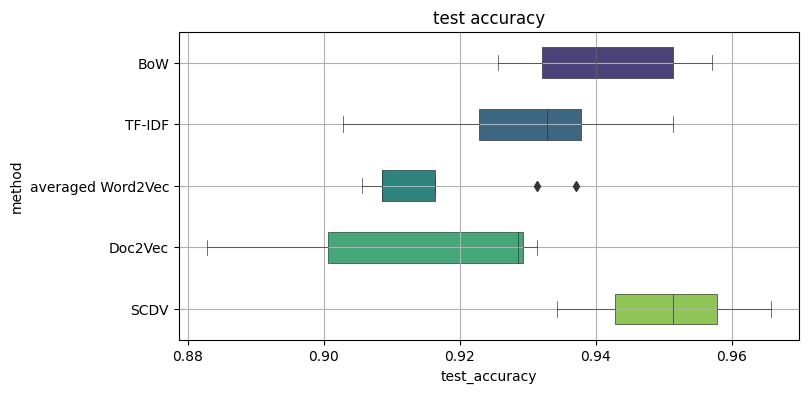

In [7]:
# Plot

plt.figure(figsize=(8, 4))
sns.boxplot(
    data=df_compare,
    y="method",
    x="test_accuracy",
    orient="h",
    palette="viridis",
    linewidth=0.5,
    width=0.5,
)
plt.grid()
plt.title("test accuracy")
plt.show()

In [8]:
df_tmp = df_compare.groupby(["method"]).agg(
    mean_train_accuracy=("train_accuracy", "mean"),
    mean_test_accuracy=("test_accuracy", "mean"),
    mean_fit_time=("fit_time", "mean"),
)
df_tmp = df_tmp.apply(lambda x: round(x, 4))
df_tmp = df_tmp.reset_index()
df_tmp = df_tmp.sort_values(by="mean_test_accuracy", ascending=False)
df_tmp

,method,mean_train_accuracy,mean_test_accuracy,mean_fit_time
2,SCDV,1.0,0.9507,454.9618
0,BoW,1.0,0.9407,118.7828
3,TF-IDF,1.0,0.9289,121.4293
1,Doc2Vec,1.0,0.9154,16.4022
4,averaged Word2Vec,1.0,0.9150,13.1568


<h2>Insights</h2>
<p><b>[1]</b> <b>SCDV</b> could produce the <b>best accuracy</b>. It seem like be also <b>further distribute even within the same category</b> in t-SNE plot.</p>
<p><b>[2]</b> <b>BoW</b> is NOT clearly distributed in t-SNE plot. However, the model accuracy is good. With these document size, BoW may be able to produce good result.</p>